<a href="https://colab.research.google.com/github/Farmhouse121/Financial-Data-Science-in-Python/blob/main/Miscellaneous/S%26P_500_Pairwise_Correlations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from my_library import *

12:53:54 Starting...
12:53:54 Installing yfinance into Google notebook...
12:54:00 Installing arch into Google notebook...
12:54:09 Initialized.


In [2]:
# let's ignore some warnings that clutter the output, skip this cell if you want to see them
from warnings import filterwarnings

for warning in UserWarning,FutureWarning:
    filterwarnings("ignore",category=warning)

In [3]:
display(sp500:=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0])

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...
498,XYL,Xylem Inc.,Industrials,Industrial Machinery & Supplies & Components,"White Plains, New York",2011-11-01,1524472,2011
499,YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
500,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
501,ZBH,Zimmer Biomet,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927


In [4]:
first_date=sp500['Date added'].max()
results=pd.DataFrame({"Sample":list(range(N:=5000))}).set_index("Sample")
nprint("Getting daily data for {:,d} pairs of index stocks, starting on {:s}.".format(N,first_date))

for i in tqdm(results.index):
    df=download(list(sp500.sample(2,axis=0)['Symbol'].apply(lambda x:x.replace(".","-"))),first_date,progress=False).dropna()

    if df.shape[0]<10:
        continue

    for ticker in (tickers:=list(set(df.columns.get_level_values(1)))):
        df[('Return',ticker)]=df[('Adj Close',ticker)].pct_change()*hundred

    df.dropna(inplace=True)
    df.index=pd.DatetimeIndex(df.index).to_period('D')

    for j in range(2):
        results.loc[i,j]=tickers[j]

    results.loc[i,"Correlation"]=df.corr().iloc[0,1]*hundred
    results.loc[i,"Sample"]=df.shape[0]

results.set_index([0,1],inplace=True)
results.index.names=["Ticker 1","Ticker 2"]
results.loc["Mean","Sample"]=results.shape[0]
results.loc["Mean","Correlation"]=(m:=results["Correlation"].mean())
display(results)

12:54:10 Getting daily data for 5,000 pairs of index stocks, starting on 2024-07-08.


  0%|          | 0/5000 [00:00<?, ?it/s]

<ipython-input-4-40d21e1adaf7>:25: PerformanceWarning: indexing past lexsort depth may impact performance.
  results.loc["Mean","Sample"]=results.shape[0]
<ipython-input-4-40d21e1adaf7>:26: PerformanceWarning: indexing past lexsort depth may impact performance.
  results.loc["Mean","Correlation"]=(m:=results["Correlation"].mean())


,,Correlation,Sample
Ticker 1,Ticker 2,,
WAB,KMI,23.114043,39.0
KO,PYPL,83.029671,39.0
TSLA,BG,75.663156,39.0
FMC,NVR,80.862167,39.0
MRO,META,7.579827,39.0
...,...,...,...
PSX,CSX,66.003912,39.0
COST,INCY,-21.370255,39.0
EXPE,USB,59.982390,39.0


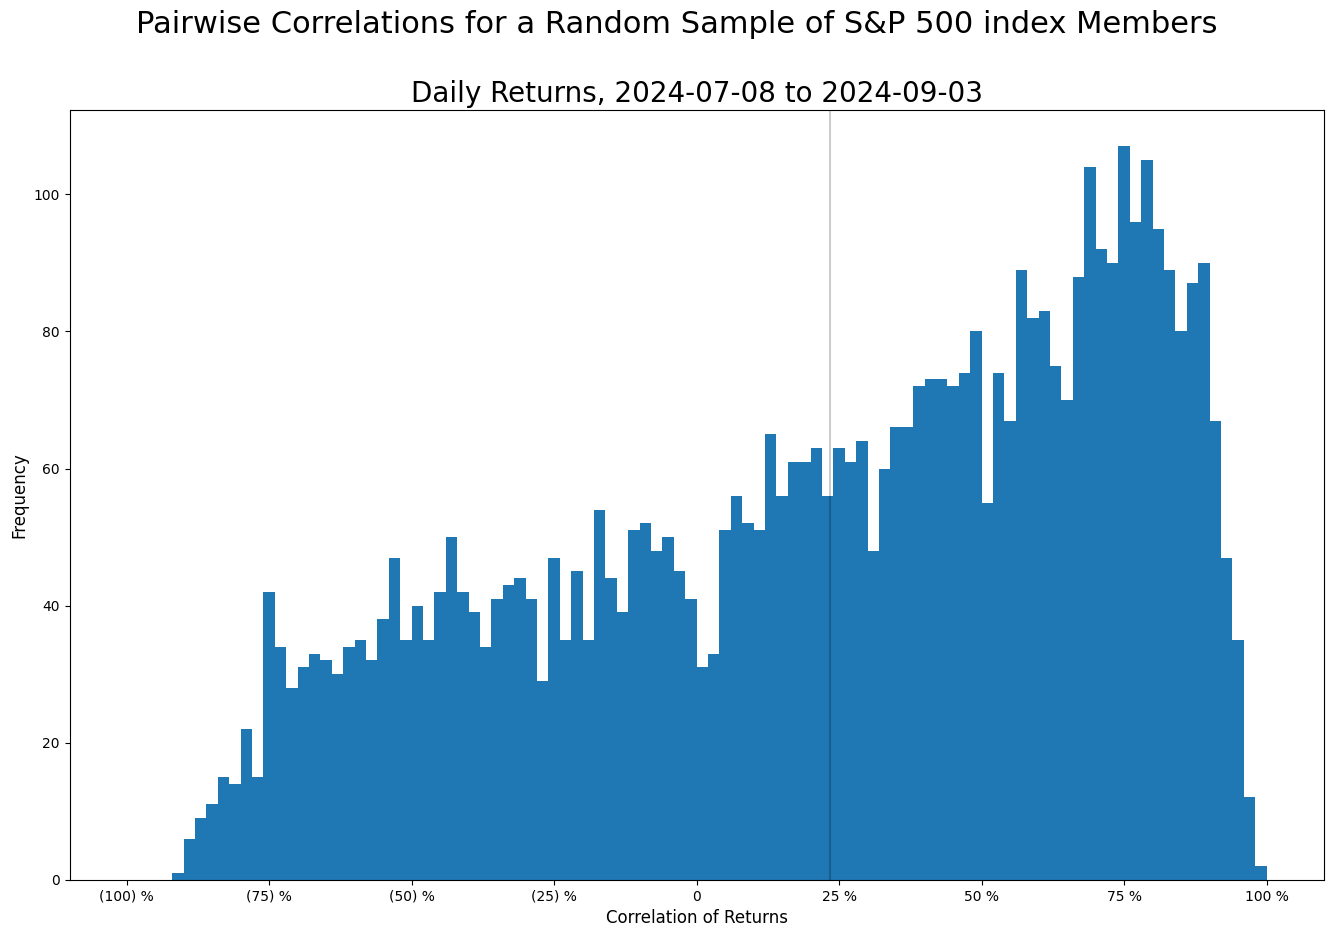

In [5]:
figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
bins,counts,patches=plot.hist(results.loc[results.index!="Mean",'Correlation'].to_numpy(),bins=np.linspace(-hundred,hundred,101))
figure.suptitle(title:="Pairwise Correlations for a Random Sample of S&P 500 index Members",fontsize=22)
plot.set_title(subtitle:="Daily Returns, %s to %s" % (first_date,today("%Y-%m-%d")),fontsize=20)
plot.set_xlabel("Correlation of Returns",fontsize=12)
plot.xaxis.set_major_formatter(PercentLabels(0))
plot.set_ylabel("Frequency",fontsize=12)
plot.yaxis.set_major_formatter(CountLabels())
plot.axvline(m,color='black',alpha=0.2)
figure.savefig(title+".png",dpi=300,bbox_inches='tight')

In [6]:
results=pd.DataFrame({"Sample":range(1,(n:=1000)+1),"Assets":[np.nan]*n,"Portfolio":[np.nan]*n}).set_index("Sample") # n is number of trials
nprint("Getting daily data for all index stocks, starting on %s." % first_date)
closes=download(list(sp500['Symbol'].apply(lambda x:x.replace(".","-"))),first_date)['Adj Close']
closes.index=pd.DatetimeIndex(closes.index).to_period('B')

nprint("Beginning analysis for {:,d} trials. This may take about {:.1f} minutes...".format(n,n/2.38/60)) # approx empirical timings

for i in tqdm(results.index): # for each trial, pick a random sample of stocks with portfolio sizes uniformly distributed between 1 and maximum, one of 2^503-1 choices
    returns=pd.DataFrame()

    for ticker in closes[np.random.choice(closes.columns,np.random.randint(1,closes.shape[1]+1),replace=False)]:
        returns[ticker]=closes[ticker].pct_change().dropna()*hundred # compute all adjusted returns, ticker by ticker

        if returns[ticker].shape[0]<1: # exclude time-series that are all NA's
            returns.drop(columns=ticker,inplace=True)

        else:
            returns=returns.copy() # 'cos it frags, apparently

    results.loc[i,"Assets"]=returns.shape[1] # number of assets we ended up with
    results.loc[i,"Independent"]=returns.var().sum()/results.loc[i,"Assets"]**2 # if no correlation, portfolio variance is total variance divided by square of number of assets
    returns['Portfolio']=returns.mean(axis=1) # equal weighted portfolio return
    results.loc[i,"Portfolio"]=returns['Portfolio'].var() # variance of portfolio returns for same period as individual returns

results.dropna(inplace=True)
results["Effective D.o.F."]=results["Independent"]/results["Portfolio"]*results["Assets"]
display(results)
nprint("Done.")

13:07:40 Getting daily data for all index stocks, starting on 2024-07-08.


[*********************100%***********************]  503 of 503 completed


13:08:18 Beginning analysis for 1,000 trials. This may take about 7.0 minutes...


  0%|          | 0/1000 [00:00<?, ?it/s]

,Assets,Portfolio,Independent,Effective D.o.F.
Sample,,,,
1,431.0,0.933175,0.010427,4.815811
2,45.0,1.138740,0.111251,4.396360
3,197.0,0.930437,0.022093,4.677679
4,34.0,0.876560,0.113186,4.390272
5,122.0,0.779268,0.035216,5.513341
...,...,...,...,...
996,51.0,0.874270,0.102323,5.968945
997,329.0,0.857710,0.012306,4.720420
998,98.0,0.948115,0.044244,4.573181


13:14:22 Done.


13:14:22 Effective D.o.F. Limit 4.85, Implied Correlation 20.44 %.


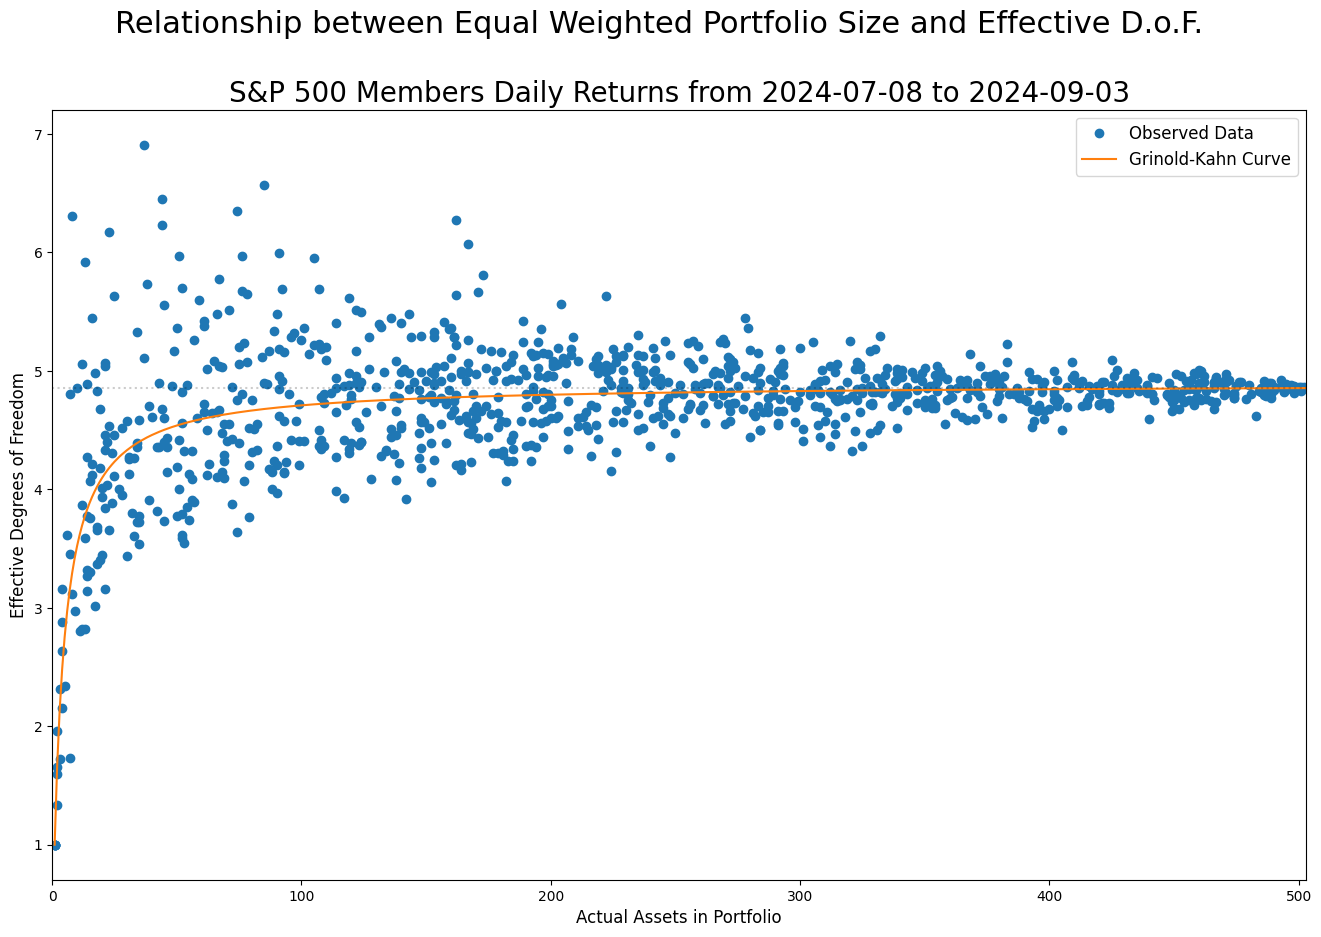

In [7]:
Nstar,Nact=tuple(results.sort_values("Assets").iloc[-1][["Effective D.o.F.","Assets"]])
rho=(Nact-Nstar)/((Nact-one)*Nstar)
nprint("Effective D.o.F. Limit {:,.2f}, Implied Correlation {:.2f} %.".format(Nstar,rho*hundred))

figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
plot.plot(x:=results["Assets"].to_numpy(),y:=results["Effective D.o.F."].to_numpy(),'o',label='Observed Data')
plot.plot(xp:=np.sort(x),xp/(one+(xp-one)*rho),'-',label='Grinold-Kahn Curve')
plot.set_xlabel("Actual Assets in Portfolio",fontsize=12)
plot.set_ylabel("Effective Degrees of Freedom",fontsize=12)
figure.suptitle(title:="Relationship between Equal Weighted Portfolio Size and Effective D.o.F.",fontsize=22)
plot.set_title("S&P 500 Members Daily Returns from %s to %s" % (first_date,pd.Timestamp.today().strftime("%Y-%m-%d")),fontsize=20)
plot.set_xlim(zero,sp500.shape[0])
plot.legend(fontsize=12)
plot.axhline(Nstar,color='black',linestyle=':',alpha=0.2)
figure.savefig(title+".png",dpi=300,bbox_inches='tight')

## LaTeX code to generate equations:
$$
V_P=\mathbb{V}\!\left[\frac{1}{N}\sum_{i=1}^Nr_{it}\right]=\frac{1}{N^2}\mathbb{V}\!\left[\sum_{i=1}^Nr_{it}\right]
$$

$$
V_P=\frac{1}{N^2}\sum_{i=1}^N\sigma_i^2+\frac{2}{N^2}\sum_{i=1}^N\sum_{j=i+1}^N\sigma_i\sigma_j\rho_{ij}=V_I+V_C
$$

$$
V_I=\frac{1}{N}\left(\frac{1}{N}\sum_{i=1}^N\sigma_i^2\right)=\frac{\overline{\sigma^2}}{N}
$$

$$
\mathbb{V}[\bar{x}]=\frac{\sigma^2}{N}\;\mathrm{where}\;\mathbb{V}[x_i]=\mathbb{V}[x_j]=\sigma^2\;\mathrm{and}\;\mathbb{C}[x_i,x_j]=0\;\forall\;i,j
$$

$$
V_P=V_I\left(1+\frac{V_C}{V_I}\right)=\frac{\overline{\sigma^2}}{N}\left(1+\frac{V_C}{V_I}\right)
$$

$$
V_P=\frac{\overline{\sigma^2}}{N^*}\;\mathrm{where}\;N^*=N\frac{V_I}{V_P}
$$